In [1]:
import numpy as np
import pandas as pd
import torch
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data, Batch
from torch_geometric.transforms import LocalDegreeProfile
import torch.nn.functional as F
from torch_geometric.datasets import GemsecDeezer
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, average_precision_score
import pathlib
import utils
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# finding the current path
base_dir = pathlib.Path().resolve()

In [2]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hid_channels, out_channels):
        super(GNN, self).__init__()
        torch.manual_seed(0)
        self.conv1 = GCNConv(in_channels=in_channels, out_channels=hid_channels)
        self.conv2 = GCNConv(in_channels=hid_channels, out_channels=hid_channels)
        self.conv3 = GCNConv(in_channels=hid_channels, out_channels=out_channels)
        # self.lin1 = torch.nn.Linear(in_features=hid_channels, out_features=out_channels)
        # self.conv4 = GATConv(in_channels=)

    def forward(self, x, edge_index, index=0):
        if index == 0:
            x = self.conv1(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv2(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv3(x, edge_index)
        elif index == 1:
            x = self.conv1(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv3(x, edge_index)
        elif index == 2:
            x = self.conv1(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv2(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv2(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv3(x, edge_index)
        elif index == 3:
            x = self.conv1(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv2(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv2(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv2(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv3(x, edge_index)
        # x = self.lin1(x)
        # x = x.sigmoid()
        return x

In [3]:
# loading the finger similarity into dataframe
df = pd.read_csv(f'{base_dir}/datasets/fingerSimilarity.csv')
# loading drug side effects file
se_df = pd.read_csv(f'{base_dir}/datasets/sideEffectsfillterd.csv')
drug_dccs = list(se_df['DCC_ID'].to_numpy())

In [4]:
indications_df = pd.read_csv(f'{base_dir}/datasets/node_feature_datasets/indicationsVec.csv')
drug_target_df = pd.read_csv(f'{base_dir}/datasets/node_feature_datasets/Drugs_Targets_Onehot.csv')
finger_df = pd.read_csv(f'{base_dir}/datasets/node_feature_datasets/Drug_finger.csv')

In [5]:
# preprocessing word2vec dataframe
w2v_df = pd.read_csv(f'{base_dir}/datasets/node_feature_datasets/word2vec.csv')

word2vecs = np.random.randn(w2v_df.shape[0], 200)
for i, row in enumerate(w2v_df.values):
    drug = row[0]
    vectors = row[1].replace('[', '').replace(']', '').replace('\n', ' ').split(' ')
    word_vectors = []
    for each in vectors:
        if each != '':
            word_vectors.append(float(each))
    for j, each in enumerate(word_vectors):
        word2vecs[i, j] = each
del w2v_df['vector']
for i in range(1, word2vecs.shape[1]+1):
    w2v_df[f'c{i}'] = list(word2vecs[:, i-1])

In [6]:
# preprocessing node2vec dataframe
n2v_df = pd.read_csv(f'{base_dir}/datasets/node_feature_datasets/Node2Vec_DCC.csv')

node2vecs = np.random.randn(n2v_df.shape[0], 128)
for row in n2v_df.values:
    drug = row[0]
    vectors = row[1].replace('[', '').replace(']', '').replace("'", ' ').split(', ')
    node_vectors = []
    for each in vectors:
        if each != '':
            node_vectors.append(float(each))
    for j, each in enumerate(node_vectors):
        node2vecs[i, j] = each
del n2v_df['Node2Vec']
for i in range(1, node2vecs.shape[1]+1):
    n2v_df[f'c{i}'] = list(node2vecs[:, i-1])

In [7]:
df_list = [n2v_df, w2v_df, indications_df, drug_target_df]
df_title_list = ['Node2Vec', 'Word2Vec', 'Indication', 'Drug Target']
graph_data_list = []
for i, each_df in enumerate(df_list):
    print(df_title_list[i])
    data = utils.create_graph_of_input_drugs(df, se_df, each_df, least_score=0.8, consider_edge_attrs=True)
    graph_data_list.append([df_title_list[i], data])

score_list = []
for row in graph_data_list:
    title = row[0]
    data = row[1]
    losses, auc_score_list, aupr_score_list = utils.train_and_test(data, GNN, 101, with_auc=True, with_aupr=True, with_f1=False, plot_training=False, print_logs=False, index=0)
    score_list.append([title, losses, auc_score_list, aupr_score_list])


Node2Vec
Data(x=[94, 128], edge_index=[2, 184], edge_attr=[184], y=[94, 641])
Word2Vec
Data(x=[101, 200], edge_index=[2, 186], edge_attr=[186], y=[101, 704])
Indication
Data(x=[74, 1513], edge_index=[2, 144], edge_attr=[144], y=[74, 601])
Drug Target
Data(x=[108, 790], edge_index=[2, 202], edge_attr=[202], y=[108, 708])


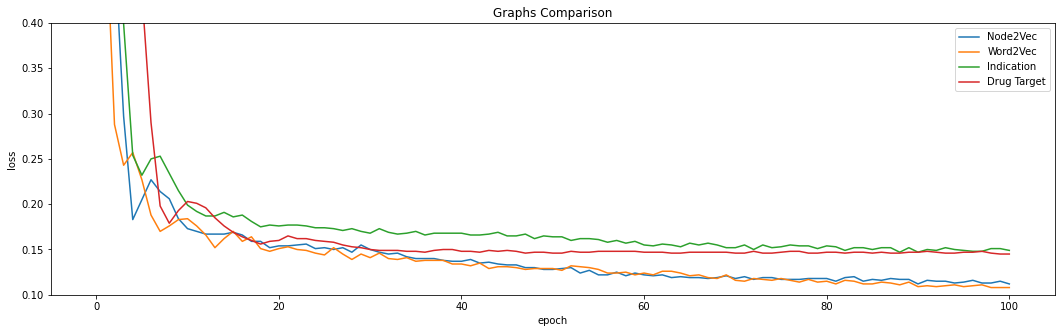

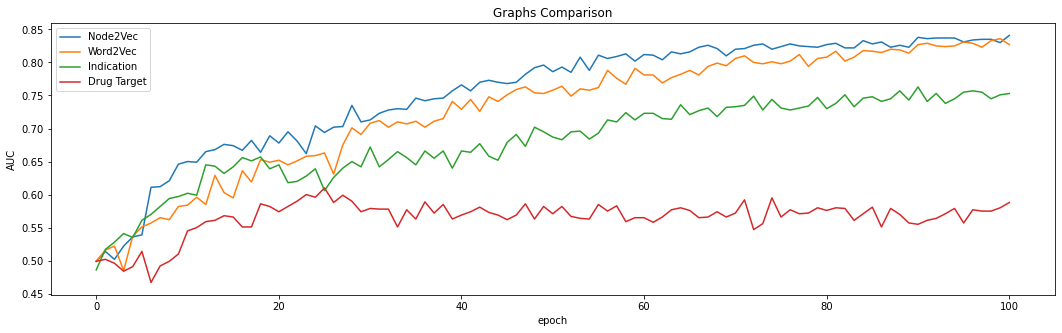

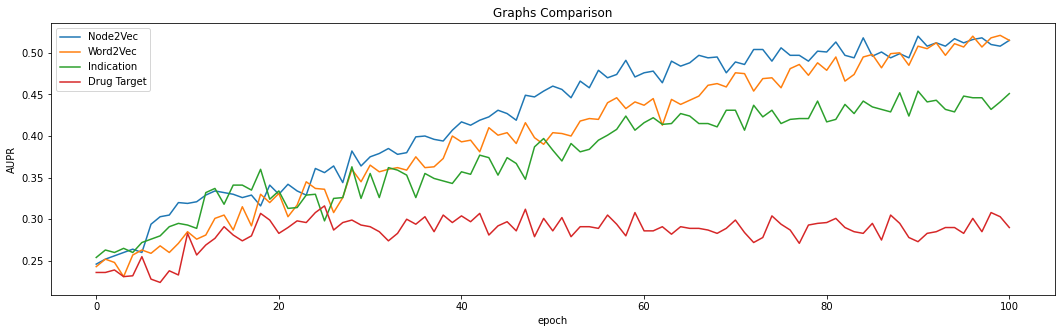

In [19]:
plt.figure(figsize=(18, 5))
for row in score_list:
    title = row[0]
    loss_list = row[1]
    auc_list = row[2]
    aupr_list = row[3]
    plt.plot(loss_list, label=title)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Graphs Comparison')
plt.ylim(0.1, 0.4)
plt.legend()
plt.show()
##############################################
plt.figure(figsize=(18, 5))
for row in score_list:
    title = row[0]
    loss_list = row[1]
    auc_list = row[2]
    aupr_list = row[3]
    plt.plot(auc_list, label=title)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('Graphs Comparison')
# plt.ylim(0.1, 0.4)
plt.legend()
plt.show()
##############################################
plt.figure(figsize=(18, 5))
for row in score_list:
    title = row[0]
    loss_list = row[1]
    auc_list = row[2]
    aupr_list = row[3]
    plt.plot(aupr_list, label=title)
plt.xlabel('epoch')
plt.ylabel('AUPR')
plt.title('Graphs Comparison')
# plt.ylim(0.1, 0.4)
plt.legend()
plt.show()

In [20]:
score_list_1 = score_list[:]

In [ ]:
max_auc_list = []
max_aupr_list = []
for row in score_list_1:
    title = row[0]
    loss_list = row[1]
    auc_list = row[2]
    aupr_list = row[3]
    max_auc_list.append(np.array(auc_list).max())
    max_aupr_list.append(np.array(aupr_list).max())
print(max_auc_list)
print(max_aupr_list)

In [21]:
df_list = [n2v_df, w2v_df, indications_df, drug_target_df]
df_title_list = ['Node2Vec', 'Word2Vec', 'Indication', 'Drug Target']
graph_data_list = []
for i, each_df in enumerate(df_list):
    print(df_title_list[i])
    data = utils.create_graph_of_input_drugs(df, se_df, each_df, least_score=0.7, consider_edge_attrs=True)
    graph_data_list.append([df_title_list[i], data])

score_list = []
for row in graph_data_list:
    title = row[0]
    data = row[1]
    losses, auc_score_list, aupr_score_list = utils.train_and_test(data, GNN, 101, with_auc=True, with_aupr=True, with_f1=False, plot_training=False, print_logs=False, index=0)
    score_list.append([title, losses, auc_score_list, aupr_score_list])


Node2Vec
Data(x=[174, 128], edge_index=[2, 604], edge_attr=[604], y=[174, 920])
Word2Vec
Data(x=[175, 200], edge_index=[2, 572], edge_attr=[572], y=[175, 904])
Indication
Data(x=[150, 1513], edge_index=[2, 484], edge_attr=[484], y=[150, 874])
Drug Target
Data(x=[193, 790], edge_index=[2, 726], edge_attr=[726], y=[193, 952])


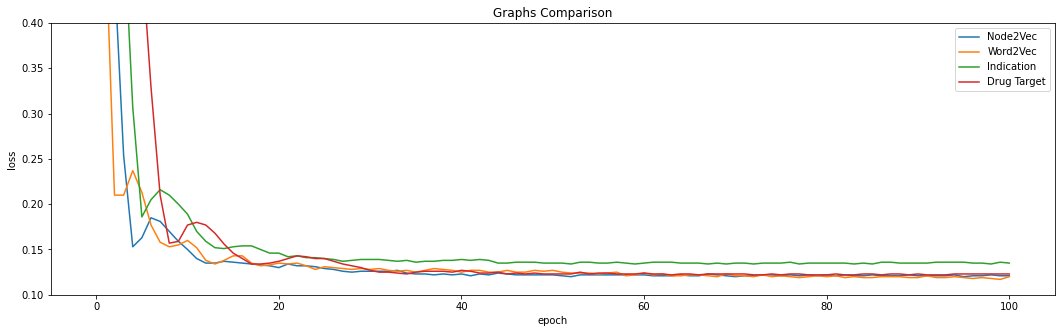

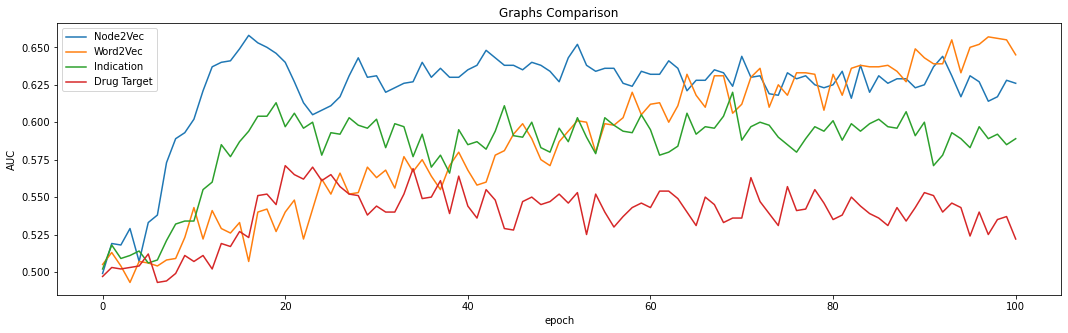

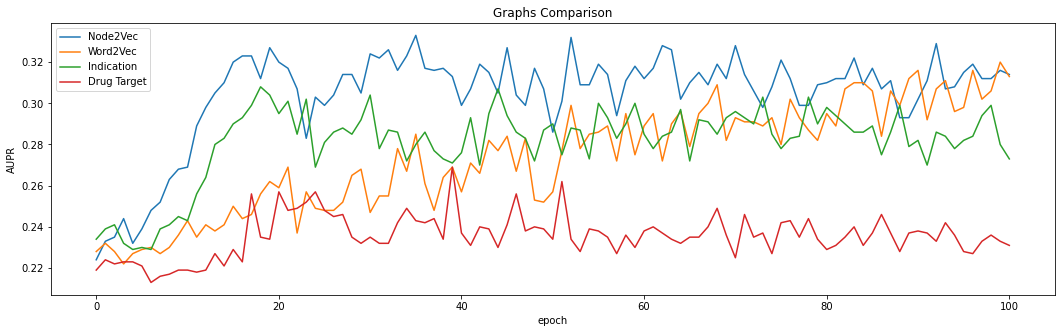

In [22]:
plt.figure(figsize=(18, 5))
for row in score_list:
    title = row[0]
    loss_list = row[1]
    auc_list = row[2]
    aupr_list = row[3]
    plt.plot(loss_list, label=title)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Graphs Comparison')
plt.ylim(0.1, 0.4)
plt.legend()
plt.show()
##############################################
plt.figure(figsize=(18, 5))
for row in score_list:
    title = row[0]
    loss_list = row[1]
    auc_list = row[2]
    aupr_list = row[3]
    plt.plot(auc_list, label=title)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('Graphs Comparison')
# plt.ylim(0.1, 0.4)
plt.legend()
plt.show()
##############################################
plt.figure(figsize=(18, 5))
for row in score_list:
    title = row[0]
    loss_list = row[1]
    auc_list = row[2]
    aupr_list = row[3]
    plt.plot(aupr_list, label=title)
plt.xlabel('epoch')
plt.ylabel('AUPR')
plt.title('Graphs Comparison')
# plt.ylim(0.1, 0.4)
plt.legend()
plt.show()

In [26]:
max_auc_list = []
last_auc_list = []
max_aupr_list = []
for row in score_list_1:
    title = row[0]
    loss_list = row[1]
    auc_list = row[2]
    aupr_list = row[3]
    max_auc_list.append(np.array(auc_list).max())
    max_aupr_list.append(np.array(aupr_list).max())
    last_auc_list.append(auc_list[-1])
print(max_auc_list)
print(max_aupr_list)
print(last_auc_list)

[0.841, 0.836, 0.763, 0.61]
[0.52, 0.521, 0.454, 0.316]
[0.841, 0.827, 0.753, 0.588]


In [28]:
max_auc_list = []
max_aupr_list = []
last_auc_list = []
for row in score_list:
    title = row[0]
    loss_list = row[1]
    auc_list = row[2]
    aupr_list = row[3]
    max_auc_list.append(np.array(auc_list).max())
    max_aupr_list.append(np.array(aupr_list).max())
    last_auc_list.append(auc_list[-1])
print(max_auc_list)
print(max_aupr_list)
print(last_auc_list)

[0.658, 0.657, 0.62, 0.571]
[0.333, 0.32, 0.308, 0.269]
[0.626, 0.645, 0.589, 0.522]
